In [45]:
import torch
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

from captum.attr import visualization as viz
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation

from CustomCNNSegmentation import SimpleResNetSegmentation

In [46]:
# Default device plus free memory
torch.cuda.empty_cache()
#device = "cpu"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [47]:
# Defined dataset
dataset_type = 'easier'

data = torch.load(f'./data/segmentation_custom_dataset/{dataset_type}_segmentation.pth')
images = data['images'].float() 
labels = data['labels'].float() 

# Create dataset
dataset = TensorDataset(images.unsqueeze(1), labels)  # Add channel dimension

# Instantiate the model
model = SimpleResNetSegmentation(num_classes=2).cuda()

# Load the weights
model.load_state_dict(torch.load(f"./Models/custom_cnn_segmentation_{dataset_type}.pth"))
model.eval()  # Set the model to evaluation mode

SimpleResNetSegmentation(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (resblock1): ResidualBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Sequential(
      (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (resblock2): ResidualBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affin

In [48]:
test_loader = DataLoader(dataset, batch_size=20, shuffle=False)

# Select a random batch from the test dataset
images, masks = next(iter(test_loader))

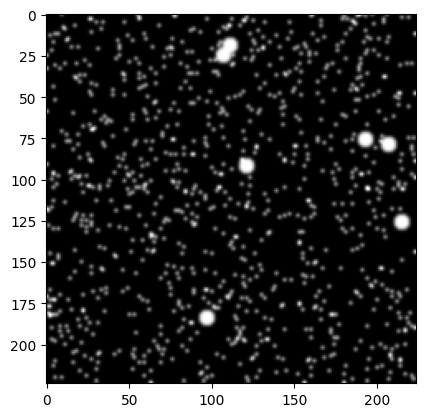

In [49]:
img = images[0]
_ = plt.imshow(img[0], cmap='gray')

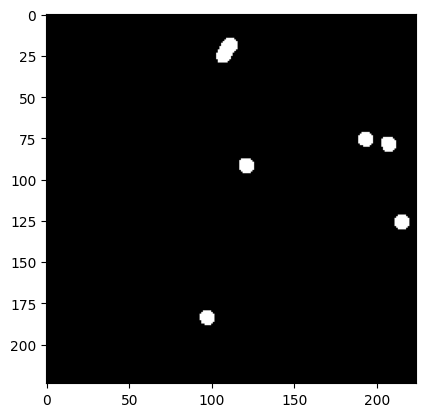

In [50]:
input = img.unsqueeze(0).to(device)

out = model(input)

# Find most likely segmentation class for each pixel.
out_max = torch.argmax(out, dim=1, keepdim=True)

_ = plt.imshow(out_max.detach().cpu().squeeze().numpy(), cmap='gray')

In [51]:
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

In [52]:
layer_analysed = model.final

lgc = LayerGradCam(agg_segmentation_wrapper, layer_analysed)


gc_attr = lgc.attribute(input, target=1)

In [53]:
la = LayerActivation(agg_segmentation_wrapper, layer_analysed)
activation = la.attribute(input)
print("Input Shape:", input.shape)
print("Layer Activation Shape:", activation.shape)
print("Layer GradCAM Shape:", gc_attr.shape)

Input Shape: torch.Size([1, 1, 224, 224])
Layer Activation Shape: torch.Size([1, 2, 224, 224])
Layer GradCAM Shape: torch.Size([1, 1, 224, 224])


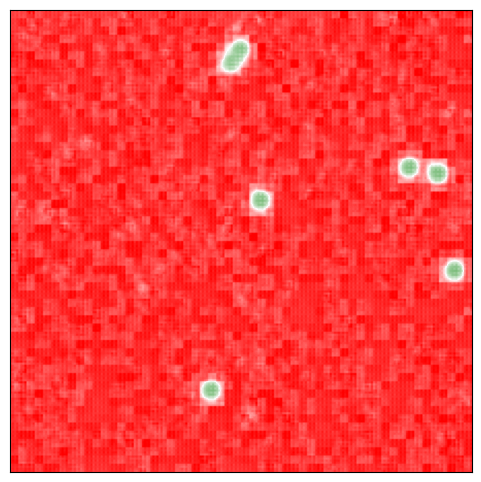

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

In [54]:
viz.visualize_image_attr(gc_attr[0].cpu().permute(1,2,0).detach().numpy(),sign="all")

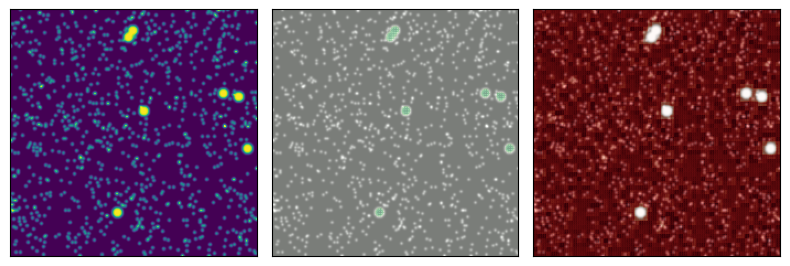

(<Figure size 800x600 with 3 Axes>,
 array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object))

In [55]:
original_image = img.cpu().permute(1,2,0).detach().numpy()
att_map = gc_attr[0].cpu().permute(1,2,0).detach().numpy()

viz.visualize_image_attr_multiple(att_map,
                                  original_image=original_image,
                                  signs=["all", "positive", "negative"],
                                  methods=["original_image", 
                                           "blended_heat_map",
                                           "blended_heat_map"])

In [56]:
fa = FeatureAblation(agg_segmentation_wrapper)
fa_attr = fa.attribute(input, 
                       feature_mask=out_max, 
                       perturbations_per_eval=2, 
                       target=1)

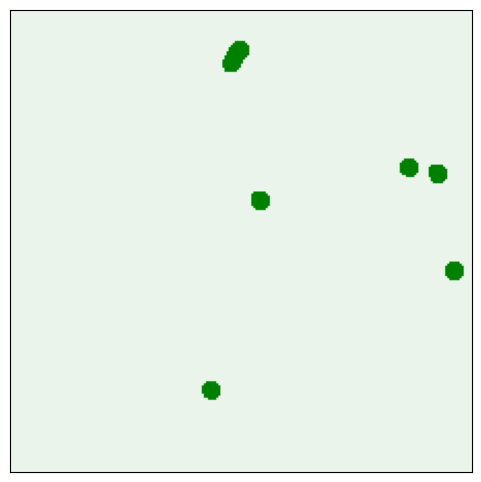

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

In [57]:
viz.visualize_image_attr(fa_attr[0].cpu().detach().permute(1,2,0).numpy(),sign="all")

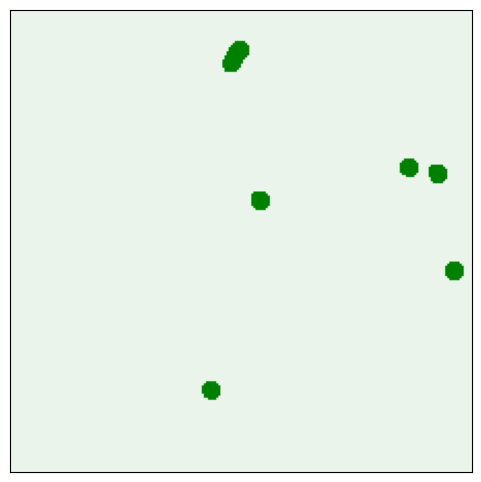

(<Figure size 600x600 with 1 Axes>, <AxesSubplot:>)

In [58]:
fa_attr_without_max = (1 - (out_max == 6).float())[0] * fa_attr
viz.visualize_image_attr(fa_attr_without_max[0].cpu().detach().permute(1,2,0).numpy(),sign="all")